## Timeseries forecasting for SPY prediction

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas_datareader.data as web
import datetime
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# enddate = str(datetime.date.today() - datetime.timedelta(days=1))
start = "01-01-1995"
today = str(datetime.date.today())
symbols = {
    "Gold": "GC=F",
    "USD_TL": "TRY=X",
    "BIST30": "XU030.IS",
}
symbol = symbols[list(symbols)[0]]
# dates = pd.date_range("2000-01-01", enddate)
df = web.DataReader("SPY", "yahoo", start=start, end=today)
# df.columns = df.columns.droplevel(1)
df = df[["Adj Close"]].rename(columns={"Adj Close": "close"})
df["returns"] = df["close"].pct_change()
df["log_returns"] = np.log(1 + df["returns"])
df.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6638 entries, 1995-01-04 to 2021-05-14
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        6638 non-null   float64
 1   returns      6638 non-null   float64
 2   log_returns  6638 non-null   float64
dtypes: float64(3)
memory usage: 207.4 KB


<IPython.core.display.Javascript object>

### Raw Data Visualization
To give us a sense of the data we are working with, each feature has been plotted below. This shows the distinct pattern of each feature over the time period. It also shows where anomalies are present, which will be addressed during normalization.

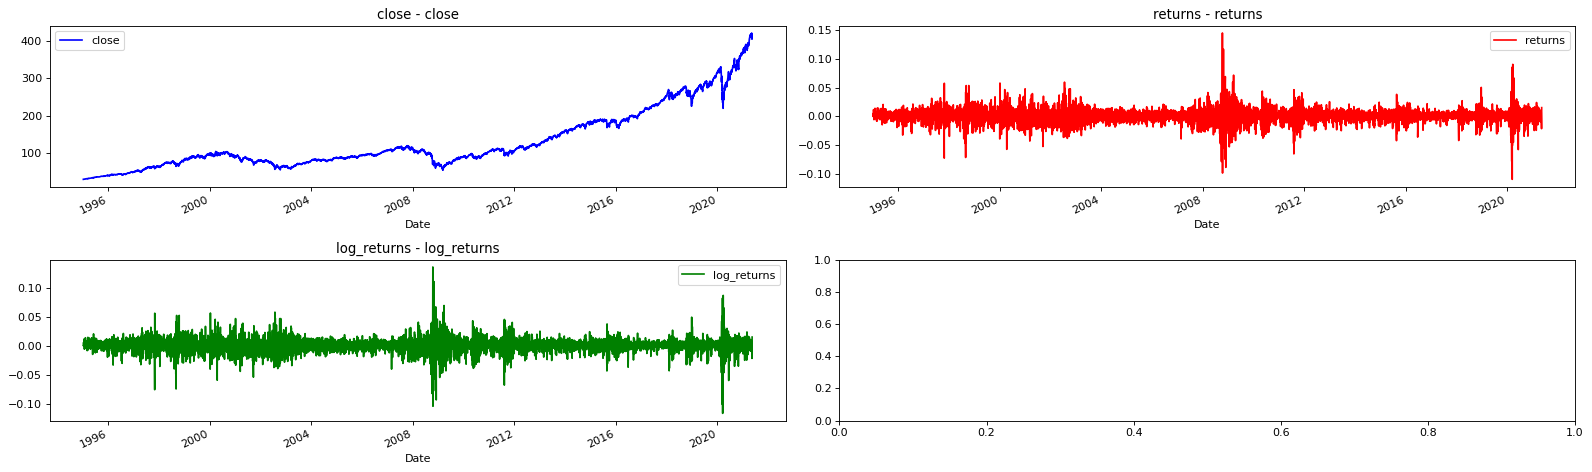

<IPython.core.display.Javascript object>

In [4]:
feature_keys = [
    "close",
    "returns",
    "log_returns",
]

colors = [
    "blue",
    "red",
    "green",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(20, 6), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(feature_keys[i], key),
            rot=25,
        )
        ax.legend([feature_keys[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6638 entries, 1995-01-04 to 2021-05-14
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        6638 non-null   float64
 1   returns      6638 non-null   float64
 2   log_returns  6638 non-null   float64
dtypes: float64(3)
memory usage: 207.4 KB


<IPython.core.display.Javascript object>

In [6]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 100
future = 5
learning_rate = 0.001
batch_size = 256
epochs = 10

def scale(data, train_split):
    scaler = StandardScaler().fit(data[:train_split])
    return scaler.transform(data[:train_split])

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


<IPython.core.display.Javascript object>

In [7]:
print(
    "The selected parameters are:",
    ", ".join([feature_keys[i] for i in [0, 1, 2]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 2]]
features = df[selected_features]
features.index = df.index
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: close, returns, log_returns


<IPython.core.display.Javascript object>

### Training dataset
The training dataset labels starts from the 792nd observation (720 + 72).

In [8]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

<IPython.core.display.Javascript object>

In [9]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

<IPython.core.display.Javascript object>

### Validation dataset
The validation dataset must not contain the last 792 rows as we won't have label data for those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add past + future (792) to label_start.

In [10]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 100, 3)
Target shape: (256, 1)


<IPython.core.display.Javascript object>

### Training

In [11]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

We'll use the ModelCheckpoint callback to regularly save checkpoints, and the EarlyStopping callback to interrupt training when the validation loss is not longer improving.

In [12]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
19/19 [==============================] - 6s 192ms/step - loss: 0.9022 - val_loss: 0.8331

Epoch 00001: val_loss improved from inf to 0.83307, saving model to model_checkpoint.h5
Epoch 2/10
19/19 [==============================] - 3s 136ms/step - loss: 0.8831 - val_loss: 0.7948

Epoch 00002: val_loss improved from 0.83307 to 0.79483, saving model to model_checkpoint.h5
Epoch 3/10
19/19 [==============================] - 3s 134ms/step - loss: 0.8777 - val_loss: 0.8030

Epoch 00003: val_loss did not improve from 0.79483
Epoch 4/10
19/19 [==============================] - 3s 137ms/step - loss: 0.8769 - val_loss: 0.7946

Epoch 00004: val_loss improved from 0.79483 to 0.79462, saving model to model_checkpoint.h5
Epoch 5/10
19/19 [==============================] - 3s 147ms/step - loss: 0.8757 - val_loss: 0.7927

Epoch 00005: val_loss improved from 0.79462 to 0.79267, saving model to model_checkpoint.h5
Epoch 6/10
19/19 [==============================] - 3s 144ms/step - loss: 0.8756

<IPython.core.display.Javascript object>

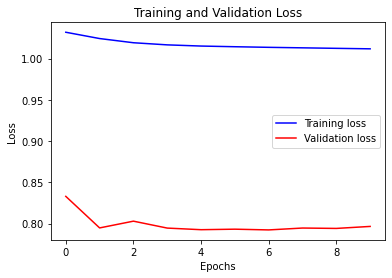

<IPython.core.display.Javascript object>

In [13]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

### Prediction
The trained model above is now able to make predictions for 5 sets of values from validation set.

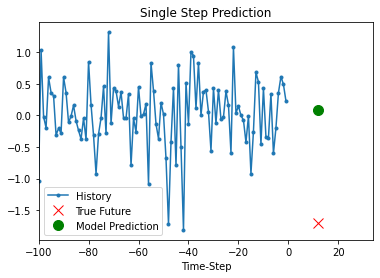

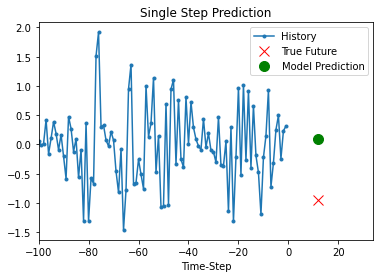

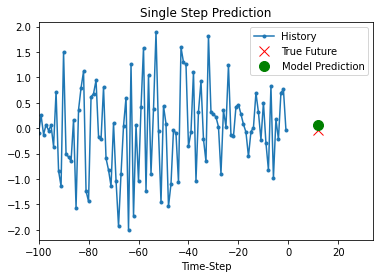

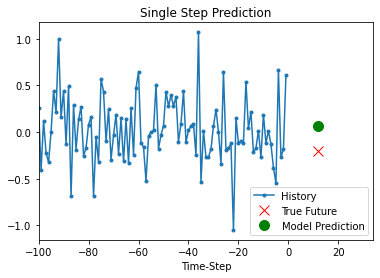

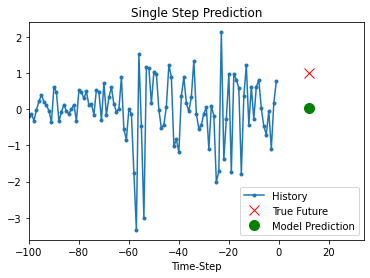

<IPython.core.display.Javascript object>

In [14]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )